In [62]:
%matplotlib inline

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

In [76]:
class FashionMNISTSet:
    def __init__(self, dim=(28,28), batch_size=32) -> None:
        composition = transforms.Compose([transforms.Resize(dim), transforms.ToTensor()])
        self.train_set = FashionMNIST(root='./dataset', train=True, download=True, transform=composition)
        self.val_set = FashionMNIST(root='./dataset', train=False, download=True, transform=composition)
        self.batch_size = batch_size
        self.dim = dim
        
    def create_dataloader(self, train: bool):
        """Create a dataloader."""
        if train:
            shuffle = True
            dataset = self.train_set
        else:
            shuffle = False
            dataset = self.val_set
        return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)

        _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow(X[i].squeeze(0), cmap='gray')
            ax.set_title(labels[i])
            ax.axis('off')

In [77]:
data = FashionMNISTSet()
len(data.train_set), len(data.val_set)

(60000, 10000)

In [78]:
im1, label1 = data.train_set[0]

In [79]:
im1.shape, label1

(torch.Size([1, 28, 28]), 9)

In [80]:
batch_test = next(iter(data.create_dataloader(train=True)))

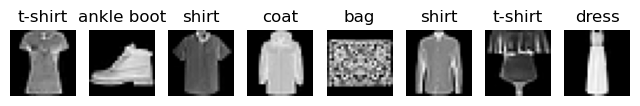

In [81]:
data.visualize(batch_test)

In [87]:
def softmax(x):
    X_exp = torch.exp(x)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

In [107]:
class Classification(torch.nn.Module):
    def __init__(self, num_in: int, num_out: int, lr=0.01, sigma=0.01) -> None:   
        super().__init__()
        
        # define model
        self.W = torch.normal(0, sigma, size=(num_in, num_out), requires_grad=True)
        self.b = torch.zeros(num_out, requires_grad=True)
    
        self.lr = lr
        self.plots = {}

    def forward(self, X):
        return softmax(torch.matmul(
            torch.reshape(X, (-1, self.W.shape[0])), self.W
        ) + self.b)
        
    def configure_optimizer(self):
        self.opt = torch.optim.SGD([self.W, self.b], lr=self.lr)
    
    def loss(self, yhat, y):
        return -torch.log(yhat[:, y]).mean()
    
    def accuracy(self, y_hat, y):
        return (y_hat.argmax(1) == y).float().mean()
    
    def train_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = self.loss(y_hat, y)
        loss.backward()
        self.opt.step()
        self.plot('train_loss', loss.item())
        return loss.item()
    
    def val_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.plot('val_loss', loss.item())
        return loss.item()
        
    def plot(self, title: str, val: float):
        if title not in self.plots:
            self.plots[title] = []
        self.plots[title].append(val)

In [108]:
X = torch.randn(2, 5)
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1659, 0.1417, 0.0629, 0.3377, 0.2917],
         [0.1305, 0.0282, 0.0419, 0.5192, 0.2802]]),
 tensor([1., 1.]))

In [109]:
data = FashionMNISTSet(dim=(28,28), batch_size=32)
model = Classification(28*28, 10, lr=0.1, sigma=0.01)
model.configure_optimizer()

train_loader = data.create_dataloader(train=True)
val_loader = data.create_dataloader(train=False)

In [111]:
epochs = 10

for epoch in range(epochs):
    for batch in train_loader:
        model.train_step(batch)
    for batch in val_loader:
        model.val_step(batch)
    print('epoch %d, train loss %.4f, val loss %.4f' % (
        epoch, model.plots['train_loss'][-1], model.plots['val_loss'][-1]))

epoch 0, train loss nan, val loss nan


KeyboardInterrupt: 